**This model is developed by Sarthak Walia, 2nd year MnC student (IIT Goa)**

I've used various resources:-
https://machinelearningmastery.com/time-series-prediction-with-deep-learning-in-python-with-keras/


**Stock Price Prediction**

Through out the model, I will be following these steps.

*   Stock Data is Collected  of AAPL "From Yahoo"
*   Preprocess the Data - Train and Test
*   Create an stacked LSTM model
*   Predict the test data and plot the output
*   Predict the future 30 days and plot the output














In [2]:
# Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
#collecting stock data
df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17')
df


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.650659
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.718646
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.859850
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.994284
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.973674
...,...,...,...,...,...,...
2019-12-11,67.775002,67.125000,67.202499,67.692497,78756800.0,67.012764
2019-12-12,68.139999,66.830002,66.945000,67.864998,137310400.0,67.183548
2019-12-13,68.824997,67.732498,67.864998,68.787498,133587600.0,68.096771


In [4]:
df.shape

(2003, 6)

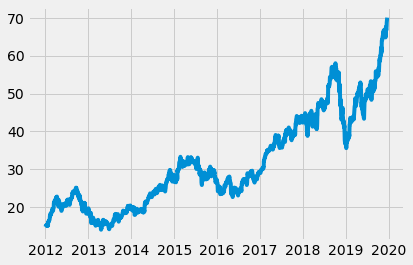

In [5]:
#plot of closing price stock
plt.plot(df['Close'])

In [6]:
#collecting value of 'Close' column from data
df1=df.reset_index()['Close']
df1

0       14.686786
1       14.765714
2       14.929643
3       15.085714
4       15.061786
          ...    
1998    67.692497
1999    67.864998
2000    68.787498
2001    69.964996
2002    70.102501
Name: Close, Length: 2003, dtype: float64

In [7]:
df1.shape

(2003,)

In [8]:
df1=np.array(df1).reshape(-1,1)

In [9]:
df1.shape

(2003, 1)

In [10]:
df1

array([[14.6867857 ],
       [14.76571369],
       [14.92964268],
       ...,
       [68.78749847],
       [69.96499634],
       [70.10250092]])

**MinMax Scaler**

Here,I'm using MinMax Scaler function to scale the value in between 0 to 1.

\begin{align*}
x'={\frac  {x-{\text{min}}(x)}{{\text{max}}(x)-{\text{min}}(x)}}
\end{align*}

In [11]:
#Transforming value from 0 to 1 
scalar=MinMaxScaler(feature_range=(0,1))
df1=scalar.fit_transform(df1)


In [12]:
df1

array([[0.01316509],
       [0.01457063],
       [0.01748985],
       ...,
       [0.97658263],
       [0.99755134],
       [1.        ]])

**Preprocessing of data**

*   Dividing into test and train




In [13]:
# split b/w test data and train data
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data, test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]



In [14]:
train_data.shape

(1301, 1)

In [15]:
test_data.shape

(702, 1)

In [16]:
# Timeseries data  ..PreProcessing of data , converting array into dataset matrix

def create_data (data, time_step=1):
  data1,data2= [], []
  for i in range(len(data)-time_step-1):
    a = data[i:(i+time_step),0]         #for i=0,     0,1,2,3,4,--------99   100
    data1.append(a)
    data2.append(data[i+time_step,0])
  return np.array(data1), np.array(data2)
  

In [17]:
# reshape into 

time_step=100    # giving 100 features for output.
x_train, y_train= create_data(train_data,time_step)
x_test, y_test =create_data(test_data,time_step)

In [18]:
x_train.shape

(1200, 100)

In [19]:
y_train

array([0.10923845, 0.11558567, 0.11997404, ..., 0.37396488, 0.37026981,
       0.37392038])

In [20]:
 x_test.shape

(601, 100)

In [21]:
y_test.shape

(601,)

In [22]:
# reshape inputs as [samples, time steps, features] which is required for LSTM Model
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)


**Creating a LSTM Model**

In [23]:
# creating the LSTM model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
19/19 [==============================] - 10s 258ms/step - loss: 0.0105 - val_loss: 0.0059
Epoch 2/100
19/19 [==============================] - 3s 182ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 3/100
19/19 [==============================] - 4s 192ms/step - loss: 4.8402e-04 - val_loss: 0.0024
Epoch 4/100
19/19 [==============================] - 4s 189ms/step - loss: 4.0467e-04 - val_loss: 0.0018
Epoch 5/100
19/19 [==============================] - 4s 232ms/step - loss: 4.0023e-04 - val_loss: 0.0017
Epoch 6/100
19/19 [==============================] - 4s 236ms/step - loss: 3.6901e-04 - val_loss: 0.0019
Epoch 7/100
19/19 [==============================] - 4s 196ms/step - loss: 3.6013e-04 - val_loss: 0.0019
Epoch 8/100
19/19 [==============================] - 3s 183ms/step - loss: 3.5871e-04 - val_loss: 0.0018
Epoch 9/100
19/19 [==============================] - 3s 180ms/step - loss: 3.3561e-04 - val_loss: 0.0020
Epoch 10/100
19/19 [==============================] - 3s 181ms

In [26]:
# Training and Test data prediction and check performance matrics
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)


In [27]:
# Inverse transform to get original values
train_predict=scalar.inverse_transform(train_predict)
test_predict=scalar.inverse_transform(test_predict)

In [28]:
# Calculate RMSE performance metrics
math.sqrt(mean_squared_error(y_train,train_predict))


24.44627474349728

In [29]:
# Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))


46.97152078454958

**Test and Train Dataset Prediction**


*   Red colour shows Prediction of test and train dataset

*   Blue colour shows overall dataset






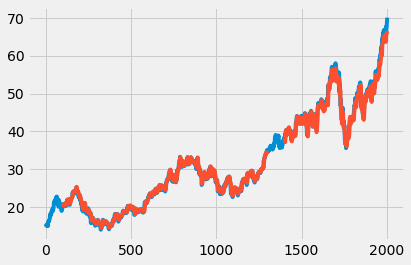

In [30]:
# Ploting 
# train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:] = train_predict

# test prediction for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
trainPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

# plot baseline and predictions

plt.plot(scalar.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


**Predicting the stock for next 30 days**

In [31]:
len(test_data)

702

In [32]:
# converting sub test data of size 100
x_input=test_data[602:].reshape(1,-1)
x_input.shape
 

(1, 100)

In [33]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.6851125896115038,
 0.6811058498488844,
 0.7000711888870204,
 0.6795476355347725,
 0.6599145291800561,
 0.6123675262240478,
 0.6286617280642937,
 0.6377437032276292,
 0.6572878192278471,
 0.6464250859325849,
 0.6441545411930747,
 0.6819517337375987,
 0.6542605168172579,
 0.6497640583786235,
 0.6709553790474521,
 0.6880954647764119,
 0.6881399599536611,
 0.6982904307550937,
 0.6974891099751972,
 0.6537707981412428,
 0.6709108838702027,
 0.6605378013193872,
 0.666636969249383,
 0.682129782378164,
 0.6809278012083191,
 0.6673937948520303,
 0.6829311710896289,
 0.7011396845251174,
 0.7010506262390506,
 0.7051019291104874,
 0.7163653907272662,
 0.7470394148809467,
 0.7448134332502541,
 0.7254919289994193,
 0.7306116595773848,
 0.7341732437728066,
 0.7433888403310265,
 0.7353307976969703,
 0.7209509074519673,
 0.725358375536103,
 0.7207282957025845,
 0.7356423998008517,
 0.7305671644001355,
 0.725803599034869,
 0.7487311826583749,
 0.7514913781423318,
 0.7264268711742001,
 0.73470752555763

In [34]:
 from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.9659323]
101
1 day input [0.68110585 0.70007119 0.67954764 0.65991453 0.61236753 0.62866173
 0.6377437  0.65728782 0.64642509 0.64415454 0.68195173 0.65426052
 0.64976406 0.67095538 0.68809546 0.68813996 0.69829043 0.69748911
 0.6537708  0.67091088 0.6605378  0.66663697 0.68212978 0.6809278
 0.66739379 0.68293117 0.70113968 0.70105063 0.70510193 0.71636539
 0.74703941 0.74481343 0.72549193 0.73061166 0.73417324 0.74338884
 0.7353308  0.72095091 0.72535838 0.7207283  0.7356424  0.73056716
 0.7258036  0.74873118 0.75149138 0.72642687 0.73470753 0.76226512
 0.76248773 0.75064549 0.76235418 0.77597718 0.80322324 0.80170952
 0.79926099 0.79503157 0.79908288 0.80411362 0.82236663 0.8199181
 0.83425336 0.83603418 0.84939007 0.86038643 0.83474308 0.83460952
 0.85909532 0.89052624 0.89800551 0.8963583  0.89684795 0.90659776
 0.90975875 0.91892979 0.91786122 0.92903569 0.92088866 0.93477877
 0.94074438 0.9371383  0.92333719 0.9180839  0.9170599  0.9374944
 0.92823437 0.94403879 0.94141215 0.9

In [35]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)


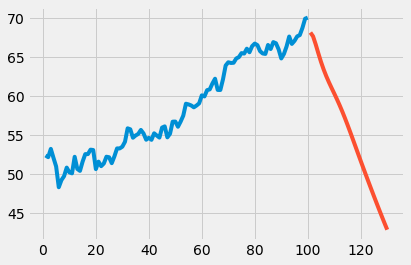

In [54]:
plt.plot(day_new,scalar.inverse_transform(df1[1903:]))
plt.plot(day_pred,scalar.inverse_transform(lst_output))

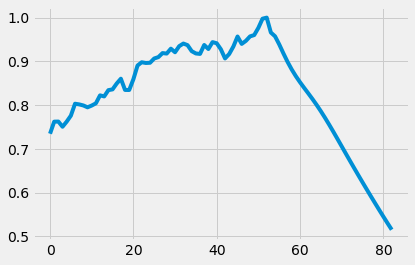

In [57]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1950:])


In [58]:
df3=scalar.inverse_transform(df3).tolist()

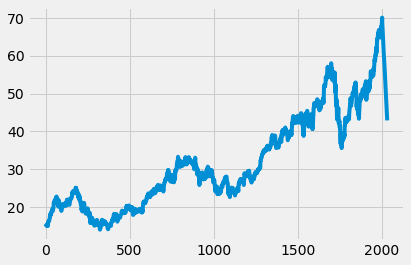

In [59]:
plt.plot(df3)